# 1 - Simple Question Classification

In this series, we'll develop a deep learning model capable of classifying questions into predefined categories using PyTorch and TorchText. This task will be performed on the [TREC question dataset](https://cogcomp.seas.upenn.edu/Data/QA/QC/), a collection of questions designed to be classified into a small set of categories.

In this initial notebook, we aim to grasp the fundamental concepts without a primary focus on achieving high accuracy. Subsequent notebooks will expand upon this foundation to improve the model's performance.

### Introduction

For analyzing sequences such as sentences in questions, we'll utilize a **recurrent neural network** (RNN). RNNs are particularly suited for sequence analysis, as they process sequences of words, $X=\{x_1, ..., x_T\}$, one at a time. Each word in the sequence is associated with a _hidden state_, $h$, which is updated sequentially. The RNN operates _recurrently_ by taking in the current word $x_t$ and the hidden state from the preceding word, $h_{t-1}$, to generate the next hidden state, $h_t$.

$$h_t = \text{RNN}(x_t, h_{t-1})$$

Upon processing the last word in the question, $x_T$, and obtaining the final hidden state, $h_T$, this state is passed through a linear layer, $f$, to predict the question's category, $\hat{y} = f(h_T)$.

## Preparing Data

For processing textual data in PyTorch, TorchText provides a powerful abstraction through the concept of `Field`. These define how to process your data, which, in the context of the TREC question classification task, includes the raw text of the question and its category label.

### Fields Definition

To process the questions and their labels, we define two fields: `TEXT` for the questions and `LABEL` for the categories.

- The `TEXT` field specifies how the questions should be processed. We employ `tokenize='spacy'` as an argument to use the [spaCy](https://spacy.io) tokenizer, which is more sophisticated than simple space-based tokenization. This requires specifying `tokenizer_language` to indicate the spaCy model to use, typically `en_core_web_sm` for English text. This model must be downloaded prior to running your notebook using the command: `python -m spacy download en_core_web_sm`.

- The `LABEL` field is managed by a `LabelField`, a variant of the `Field` designed for handling categorical data. The `dtype` argument will be clarified subsequently, ensuring the labels are processed appropriately for classification.

For a deeper dive into `Fields` and their configuration, refer to [this Documentation](https://torchtext.readthedocs.io/en/latest/data.html#field).

### Random Seed for Reproducibility

To ensure that our experiments can be replicated, we set the random seed at the beginning of our preprocessing script. This controls the randomness involved in splitting the dataset and initializing the model weights, making our results reproducible.


In [26]:
import torch
import numpy as np
import random

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [27]:
!pip install spacy

In [28]:
import sys
!{sys.executable} -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [29]:
import spacy

nlp = spacy.load("en_core_web_sm")

KeyboardInterrupt: 

In [ ]:
!{sys.executable} -m pip install  torchtext==0.4.0


In [ ]:
from torchtext import data
import torch

# For tokenization
TEXT = data.Field(tokenize='spacy',
                  tokenizer_language='en_core_web_sm',
                  include_lengths=True)

# For multi-class classification labels
LABEL = data.LabelField()

Another convenient aspect of TorchText is its built-in support for widely recognized datasets in natural language processing (NLP).

The code snippet below will automatically download the TREC question classification dataset and split it into standard train/test divisions as `torchtext.datasets` objects. It processes the data using the `Fields` we previously defined. The TREC dataset consists of thousands of questions that are categorized into both coarse-grained and fine-grained labels indicating the type of question (e.g., location, person, numeric information).



**Note:** In this example, `fine_grained=False` specifies that we want to use the coarse label set. If you're interested in a more detailed classification, you can set `fine_grained=True` to use the fine-grained label set instead.

In [ ]:
from torchtext import datasets

# Load the TREC dataset
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

We can see how many examples are in each split by checking their length.

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

We can also check an example.

In [ ]:
print(vars(train_data.examples[0]))

The TREC dataset, like the IMDb dataset, comes primarily with train and test splits, necessitating the creation of a validation set for a comprehensive evaluation process. We can achieve this through the use of the `.split()` method on the training data.

While the default behavior of `.split()` divides the data into a 70/30 split, this can be customized with the `split_ratio` parameter. For example, setting `split_ratio` to 0.8 indicates that 80% of the data will be used for training, while the remaining 20% forms the validation set.

To ensure consistency in our splits across different runs, we'll use the `random_state` parameter, passing in our predefined random seed. This guarantees that we receive the same train/validation split each time we execute our code.

Here is how you can apply this to the TREC dataset:



This approach allows us to maintain a structured and effective training regime, ensuring that our model is not only trained but also validated on a distinct subset of the dataset before being evaluated on the test set.

In [ ]:
from torchtext.data import Dataset

# Assuming train_data is already defined
train_data, valid_data = train_data.split(split_ratio=0.8, random_state=random.seed(SEED))

Again, we'll view how many examples are in each split.

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Next, we proceed to construct a _vocabulary_ for our dataset. This step is critical as machine learning models don't process raw text but numbers. The vocabulary serves as a lookup table where every unique word across the dataset is associated with a unique _index_ (an integer).

In practice, each word's _index_ is utilized to generate a _one-hot_ vector, which is a sparse vector where all elements are 0, except for the position corresponding to the word's index, which is set to 1. The total number of unique words in the dataset defines the dimensionality of these one-hot vectors, often represented by $V$.

Given the potentially vast size of our dataset's vocabulary, direct utilization of one-hot vectors can lead to inefficiencies in training and model size, especially considering some words might be very rare or unique to specific examples.

To mitigate this, we can limit our vocabulary in two ways: either by retaining only the top $n$ most frequent words or by excluding words that appear fewer than $m$ times within the dataset. For the TREC task, we'll adopt the former strategy, focusing on the most common words to ensure our model's manageability and performance.

Words not included in our reduced vocabulary are replaced with a special _unknown_ (`<unk>`) token. This approach ensures that our model can handle any word, even those not explicitly learned during training. For instance, if we encounter a sentence like "What is the capital of France?" and "capital" was not among the retained vocabulary words, it would be represented as "What is the `<unk>` of France?" in our processed data.

Here's how we can build the vocabulary for the TREC dataset, specifying a `max_size` to limit its scope:

In [ ]:
TEXT.build_vocab(train_data, max_size=10000)
LABEL.build_vocab(train_data)

Why do we only build the vocabulary on the training set? When testing any machine learning system you do not want to look at the test set in any way. We do not include the validation set as we want it to reflect the test set as much as possible.

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

We can also see the vocabulary directly using either the `stoi` (**s**tring **to** **i**nt) or `itos` (**i**nt **to**  **s**tring) method.

In [ ]:
# Assuming TEXT.vocab has been built
for i in range(10):
    print(TEXT.vocab.itos[i])


Note there are two additional tokens: the `<unk>` token and the `<pad>` token.

When we feed sentences into our model, we feed a _batch_ of them at a time, i.e. more than one at a time, and all sentences in the batch need to be the same size. Thus, to ensure each sentence in the batch is the same size, any shorter than the longest within the batch are padded.

We can also view the most common words in the vocabulary and their frequencies.

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

We can also check the labels.

In [ ]:
print(LABEL.vocab.stoi)

In [ ]:
TEXT.__dict__

The final step of preparing the data is creating the iterators. We iterate over these in the training/evaluation loop, and they return a batch of examples (indexed and converted into tensors) at each iteration.

We'll use a `BucketIterator` which is a special type of iterator that will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.

We also want to place the tensors returned by the iterator on the GPU (if you're using one). PyTorch handles this using `torch.device`, we then pass this device to the iterator.

In [ ]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

In [ ]:
BATCH_SIZE = 64

# device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    device=device)


## Build the Model

As we progress, our next objective is to construct the model that will be trained and evaluated on the TREC question classification task.

Creating models in PyTorch involves a bit of standardized code. Observe how our `RNN` class extends `nn.Module`, leveraging `super` to initialize it properly.

Within the `__init__` method, we establish the model's _layers_. For our task, these include an _embedding_ layer, the RNN itself, and a _linear_ layer to output predictions. By default, these layers have randomly initialized parameters.

The _embedding_ layer transforms sparse one-hot vectors (mostly zeros) into dense embedding vectors. This layer acts as a fully connected network that not only reduces input dimensionality but also groups semantically similar words closer in the embedding space. Embeddings are crucial for capturing the nuances of language in a computationally efficient manner.

Following is the RNN layer, which processes the dense vector alongside the previous hidden state, $h_{t-1}$, to compute the subsequent hidden state, $h_t$. This recurrent processing allows the model to maintain a memory of past words as it moves through a sentence, essential for understanding the context and classifying questions accurately.

The final step in our model involves the linear layer, which takes the RNN's last hidden state and projects it onto the space of our label categories, effectively determining the question's classification.

During the `forward` method execution, we feed batches into our model. Each batch, `text`, is a tensor of dimensions _**[sentence length, batch size]**_, representing a batch of sentences where words are indicated by their indices.

Though one might expect an additional dimension for one-hot vectors, PyTorch efficiently uses the index values directly, a process known as *numericalizing*.

After passing through the embedding layer to obtain `embedded` (dimension _**[sentence length, batch size, embedding dim]**_), this tensor is input into the RNN. PyTorch's RNN can automatically start with an all-zero initial hidden state if none is provided.

The RNN outputs two tensors: `output`, with size _**[sentence length, batch size, hidden dim]**_, representing the hidden state across all steps, and `hidden`, size _**[1, batch size, hidden dim]**_, the final hidden state. We use `hidden` to confirm our understanding, applying `squeeze` to remove any singleton dimensions.

The prediction is generated by passing `hidden` through the linear layer, `fc`, aligning it with our classification goals.

In [ ]:
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(embedding_dim, hidden_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        #text = [sent len, batch size]

        embedded = self.embedding(text)
        #embedded = [sent len, batch size, emb dim]

        output, hidden = self.rnn(embedded)
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]

        assert torch.equal(output[-1, :, :], hidden.squeeze(0))

        return self.fc(hidden.squeeze(0))

We now create an instance of our RNN class.

The input dimension is the dimension of the one-hot vectors, which is equal to the vocabulary size.

The embedding dimension is the size of the dense word vectors. This is usually around 50-250 dimensions, but depends on the size of the vocabulary.

The hidden dimension is the size of the hidden states. This is usually around 100-500 dimensions, but also depends on factors such as on the vocabulary size, the size of the dense vectors and the complexity of the task.

The output dimension is usually the number of classes.

In [ ]:
VOCAB_SIZE = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 50
OUTPUT_DIM = len(LABEL.vocab)

model = RNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

Let's also create a function that will tell us how many trainable parameters our model has so we can compare the number of parameters across different models.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

## Train the Model

Now, we'll proceed to configure the training phase and then embark on training our model.

Initially, we select an optimizer, a crucial component in the training process. The optimizer is responsible for updating the model's parameters in response to the computed gradients during training. For our purposes, we'll employ _stochastic gradient descent_ (SGD) as our optimization algorithm. SGD is a popular choice due to its simplicity and effectiveness in various tasks, including NLP. The optimizer requires two primary inputs: the parameters to update and the learning rate, which determines the magnitude of the updates during the training process.

Here's how you can set up SGD for our model:

In [ ]:
import torch.optim as optim

# Assume model is an instance of our RNN class
optimizer = optim.SGD(model.parameters(), lr=0.01)

Next, we'll define our loss function, often referred to as a criterion in PyTorch terminology.

For the TREC question classification task, which involves categorizing questions into multiple categories, the appropriate loss function is _cross-entropy loss_. This loss function is well-suited for multi-class classification problems.

Unlike the binary case, where the model outputs a single scalar representing the probability of the positive class, in multi-class classification, the model outputs a vector of scores for each class. We aim to have the score for the correct class to be higher than those for all other classes.

PyTorch provides `nn.CrossEntropyLoss` for this purpose, which combines a `softmax` layer and the cross-entropy loss in a single class. This means it first applies the softmax function to the model's outputs (to obtain probabilities across classes) and then computes the cross-entropy loss between these probabilities and the target distribution.

Here's how you can define the criterion for the TREC task:

In [ ]:
criterion = nn.CrossEntropyLoss()

It's important to note that when using `nn.CrossEntropyLoss`, the target labels for your training data should be encoded as class indices (e.g., `0` for the first class, `1` for the second class, etc.), rather than one-hot vectors. Additionally, the input to this loss function (i.e., the model's output) should not have the softmax function applied; `nn.CrossEntropyLoss` expects raw scores because it internally applies the softmax.

Using `.to`, we can place the model and the criterion on the GPU (if we have one).

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

The `train` function iterates over all examples, one batch at a time.

`model.train()` is used to put the model in "training mode", which turns on _dropout_ and _batch normalization_. Although we aren't using them in this model, it's good practice to include it.

For each batch, we first zero the gradients. Each parameter in a model has a `grad` attribute which stores the gradient calculated by the `criterion`. PyTorch does not automatically remove (or "zero") the gradients calculated from the last gradient calculation, so they must be manually zeroed.

We then feed the batch of sentences, `batch.text`, into the model. Note, you do not need to do `model.forward(batch.text)`, simply calling the model works. The `squeeze` is needed as the predictions are initially size _**[batch size, 1]**_, and we need to remove the dimension of size 1 as PyTorch expects the predictions input to our criterion function to be of size _**[batch size]**_.

The loss and accuracy are then calculated using our predictions and the labels, `batch.label`, with the loss being averaged over all examples in the batch.

We calculate the gradient of each parameter with `loss.backward()`, and then update the parameters using the gradients and optimizer algorithm with `optimizer.step()`.

The loss and accuracy is accumulated across the epoch, the `.item()` method is used to extract a scalar from a tensor which only contains a single value.

Finally, we return the loss and accuracy, averaged across the epoch. The `len` of an iterator is the number of batches in the iterator.



In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    total_correct = 0
    total_instances = 0

    model.train()

    for batch in iterator:
        optimizer.zero_grad()

        text, text_lengths = batch.text

        # Assuming your model's forward method automatically handles padding, then no need to pack sequence here
        predictions = model(text, text_lengths)

        loss = criterion(predictions, batch.label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Compute the number of correct predictions
        _, predicted_classes = predictions.max(dim=1)
        correct_predictions = (predicted_classes == batch.label).float()  # Convert to float for summation
        total_correct += correct_predictions.sum().item()
        total_instances += batch.label.size(0)

    epoch_acc = total_correct / total_instances

    return epoch_loss / len(iterator), epoch_acc

`evaluate` is similar to `train`, with a few modifications as you don't want to update the parameters when evaluating.

`model.eval()` puts the model in "evaluation mode", this turns off _dropout_ and _batch normalization_. Again, we are not using them in this model, but it is good practice to include them.

No gradients are calculated on PyTorch operations inside the `with no_grad()` block. This causes less memory to be used and speeds up computation.

The rest of the function is the same as `train`, with the removal of `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()`, as we do not update the model's parameters when evaluating.

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    total_correct = 0
    total_instances = 0

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text

            # Assuming your model's forward method automatically handles padding, then no need to pack sequence here
            predictions = model(text, text_lengths)

            loss = criterion(predictions, batch.label)
            epoch_loss += loss.item()

            # Compute the number of correct predictions
            _, predicted_classes = predictions.max(dim=1)
            correct_predictions = (predicted_classes == batch.label).float()  # Convert to float for summation
            total_correct += correct_predictions.sum().item()
            total_instances += batch.label.size(0)

    epoch_acc = total_correct / total_instances
    return epoch_loss / len(iterator), epoch_acc

We'll also create a function to tell us how long an epoch takes to compare training times between models.

In [ ]:
import time


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We then train the model through multiple epochs, an epoch being a complete pass through all examples in the training and validation sets.

At each epoch, if the validation loss is the best we have seen so far, we'll save the parameters of the model and then after training has finished we'll use that model on the test set.

In [ ]:
from tqdm import tqdm


def experiment(model, optimizer, criterion, N_EPOCHS=100, pack=False):
    best_valid_loss = float('inf')
    best_valid_acc = 0
    with tqdm(total=N_EPOCHS, desc='Training Progress') as pbar:
        for epoch in range(N_EPOCHS):
            train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
            valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_valid_acc = valid_acc
                torch.save(model.state_dict(), 'tut1-model.pt')

            pbar.set_description(
                f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%'
                f' |  Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}% |')
            pbar.update(1)
    return best_valid_loss, best_valid_acc

In [ ]:
def test(model):
    model.load_state_dict(torch.load('tut1-model.pt'))
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    return test_loss, test_acc

You may have noticed the loss is not really decreasing and the accuracy is poor. This is due to several issues with the model which we'll improve in the next notebook.

Finally, the metric we actually care about, the test loss and accuracy, which we get from our parameters that gave us the best validation loss.

In [ ]:
import time

val_accs = []
val_losses = []
times = []
for i in range(10):
    model = RNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    val_loss, val_acc = experiment(model, optimizer, criterion)
    end_time = time.time()

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    times.append(end_time - start_time)

# loss, acc = test(model)

In [ ]:
print(f'mean duration : {np.array(times).mean()}')
print(f'mean test acc : {np.array(val_accs).mean()}')

You may have noticed the loss is not really decreasing and the accuracy is poor. This is due to several issues with the model which we'll improve in the next notebook.

Finally, the metric we actually care about, the test loss and accuracy, which we get from our parameters that gave us the best validation loss.

## Next Steps

In the next notebook, you will work on improving the model to give better performances according to the Assignment instructions (including but not limited to):
- Configuration Optimization
  
  - different hyperparameters, e.g., optimizer, learning rate, batch size, size of the hidden vector
  - regularization
  - packed padded sequences

- Input Embedding

  - pre-trained word embeddings

- Output Embedding

  - sentence embedding computation

- Architecture Optimization

  - bidirectional RNN
  - multi-layer RNN
  - LSTM or GRU

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


def is_sorted(sequence):
    return all(sequence[i] >= sequence[i + 1] for i in range(len(sequence) - 1))


class packed_RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(embedding_dim, hidden_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        assert is_sorted(text_lengths)

        #text = [sent len, batch size]
        embedded = self.embedding(text)
        #embedded = [sent len, batch size, emb dim]

        packed_input = pack_padded_sequence(embedded, text_lengths)

        packed_output, ht = self.rnn(packed_input)

        return self.fc(ht.squeeze(0))

In [ ]:
val_accs = []
val_losses = []
times = []
for i in range(10):
    model = packed_RNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    val_loss, vall_acc = experiment(model, optimizer, criterion)
    end_time = time.time()

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    times.append(end_time - start_time)

In [ ]:
print(f'mean duration : {np.array(times).mean()}')
print(f'mean test acc : {np.array(val_accs).mean()}')

# 1.b
I conducted a sweep of parameters:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb

WANDB_PROJECT = "Deep Learning models for Sentence Classification"
WANDB_ENTITY = "crutch"

# Initialize W&B API
api = wandb.Api()

# Get all runs
runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")

In [3]:
sweep_01_b_runs = [run for run in runs if 'sweep_01_b' in run.tags]
print(f"✅ Found {len(sweep_01_b_runs)} runs")

✅ Found 300 runs


In [4]:
import pandas as pd


def extract(run):
    config = run.config
    return {
        "lr": config["lr"],
        "hidden_dim": config["model"]["hidden_dim"],
        "batch_size": config["batch_size"],
        "optimizer": config["optimizer"],
        "valid_acc": run.summary["valid_acc"],
    }


def load_to_df(runs):
    hparams = [extract(run) for run in runs]
    df = pd.DataFrame(hparams)
    return df

In [5]:
sweep_01_b_df = load_to_df(sweep_01_b_runs)

In [8]:
from utils import grid

In [37]:
 sweep_01_b_df.groupby(["lr","optimizer"]).agg({"valid_acc":["mean"]})[("valid_acc","mean")].unstack()

optimizer,adadelta,adagrad,adam,rmsprop,sgd
lr,,,,,
0.00001,0.173904,0.204837,0.465953,0.475963,0.194801
0.00010,0.211086,0.306651,0.727370,0.722401,0.236009
0.00100,0.280810,0.614602,0.725076,0.729817,0.352523
0.01000,0.538685,0.719113,0.390291,0.366590,0.704664
0.10000,0.731927,0.452752,0.232110,0.228965,0.603539


✅ Saved figure to report/figures/


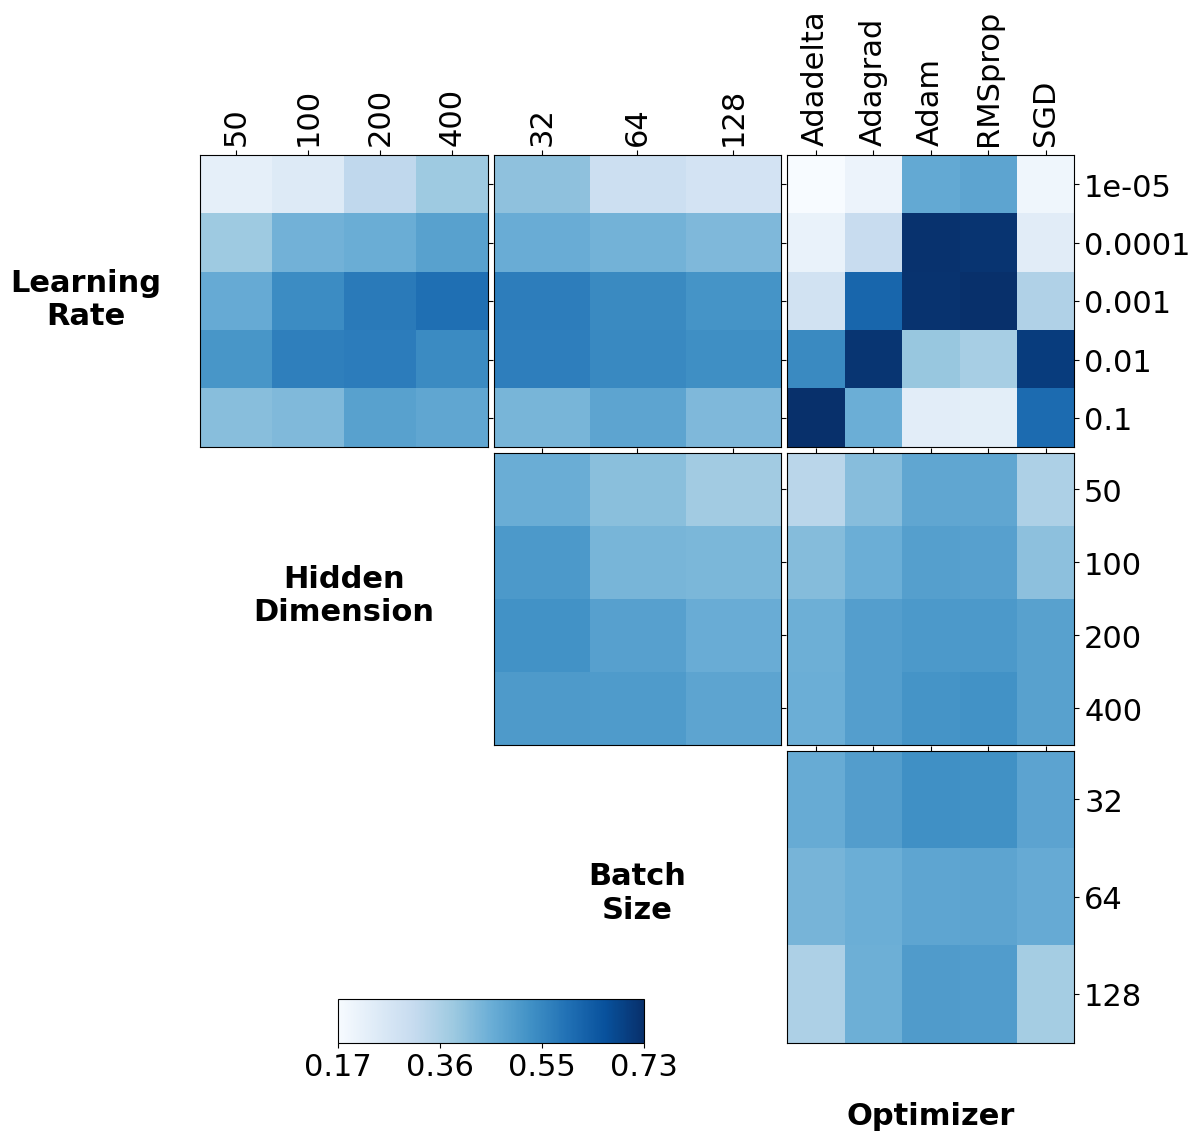

In [82]:
import os

# Choose hyperparameters to visualise
result_column = "valid_acc"
metric = "mean"
param_cols = sweep_01_b_df.columns.tolist()
param_tuples = [param for param in param_cols if param != result_column]
subset = sweep_01_b_df[
    # sweep_01_b_df[("config", "use_sot")]
    # & sweep_01_b_df[("config", "dataset")].isin(["tabula_muris"]) &
    (sweep_01_b_df[("valid_acc")] >= 0)
    ]

rename = {
    "lr": "Learning\nRate",
    "hidden_dim": "Hidden\nDimension",
    "batch_size": "Batch\nSize",
    "optimizer": "Optimizer",
    "adagrad": "Adagrad",
    "adam": "Adam",
    "sgd": "SGD",
    "rmsprop": "RMSprop",
    "adadelta": "Adadelta",
}

fig = grid(
    subset, param_tuples, result_column,metric, cmap="Blues", figsize=(10, 10), rename_dict=rename 
)  # vmin, vmax automatically set

FIGURE_DIR = "report/figures/"

fig.savefig(
    os.path.join(FIGURE_DIR, "hparam_interaction.png"),
    bbox_inches="tight",
    dpi=300,
)
print(f"✅ Saved figure to {FIGURE_DIR}")